<h1> Circuit Node Classification using Graph Convolutional Networks </h1>

In [1]:
#importing dependencies

import numpy as np
import os
import networkx as nx
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from spektral.layers import GCNConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# parse the data

In [2]:
import sys
sys.path.append('../lib')
from data_pre_processing import load_data
sys.path.remove('../lib')
A, X, labels = load_data('c5315', '../data/output')
N = X.shape[0] #the number of nodes
F = X.shape[1]
num_classes = len(set(labels))
print('X shape: ', X.shape)
print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))

(5315, 5315)
(5315, 4)
X shape:  (5315, 4)

Number of nodes (N):  5315

Number of features (F) of each node:  4

Categories:  {'eo', 'ho'}


<h3> Training, validation, and test then set the mask</h3>

In [3]:
def limit_data(labels,limit=20,val_num=500,test_num=1000):
    '''
    Get the index of train, validation, and test data
    '''
    label_counter = dict((l, 0) for l in labels)
    train_idx = []

    for i in range(len(labels)):
        label = labels[i]
        if label_counter[label]<limit:
            #add the example to the training data
            train_idx.append(i)
            label_counter[label]+=1
        
        #exit the loop once we found 20 examples for each class
        if all(count == limit for count in label_counter.values()):
            break
    
    #get the indices that do not go to traning data
    rest_idx = [x for x in range(len(labels)) if x not in train_idx]
    #get the first val_num
    val_idx = rest_idx[:val_num]
    test_idx = rest_idx[val_num:(val_num+test_num)]
    return train_idx, val_idx,test_idx


train_idx,val_idx,test_idx = limit_data(labels)

In [4]:
#set the mask
train_mask = np.zeros((N,),dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,),dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,),dtype=bool)
test_mask[test_idx] = True

<h3>Show Data Distribution</h3>

In [5]:
print("All Data : \n{}".format(Counter(labels)))
print("Training Data: \n{}".format(Counter([labels[i] for i in train_idx])))
print("Validation Data : \n{}".format(Counter([labels[i] for i in val_idx])))

All Data : 
Counter({'eo': 4716, 'ho': 599})
Training Data: 
Counter({'eo': 20, 'ho': 20})
Validation Data : 
Counter({'eo': 500})


<h3>Convert the labels to one hot encoding</h3>

In [6]:
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_

labels_encoded, classes = encode_label(labels)

<h2> Building and Training Graph Convolutional Networks </h2>

In [7]:
# Parameters
channels = 16           # Number of channels in the first layer
dropout = 0.5           # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-2    # Learning rate
epochs = 200            # Number of training epochs
es_patience = 10        # Patience for early stopping

# Preprocessing operations
A = GCNConv.preprocess(A).astype('f4')

# Model definition
X_in = Input(shape=(F, ))
fltr_in = Input((None, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GCNConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GCNConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_2, fltr_in])

# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_GCN_cora',
)
callback_GCN = [tbCallBack_GCN]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4)            0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
gcn_conv (GCNConv)              (None, 16)           64          dropout[0][0]                    
                                                                 input_2[0][0]                

In [8]:
X = X.toarray()
#A = A.toarray()

In [9]:
# Train model
# X = X.toarray()
# A = A.toarray()
validation_data = ([X, A], labels_encoded, val_mask)
model.fit([X, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[
              EarlyStopping(patience=es_patience,  restore_best_weights=True),
              tbCallBack_GCN
          ])

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 0.0114 - acc: 0.7000 - val_loss: 0.1855 - val_acc: 0.2020
Epoch 2/200
1/1 [==============================] - 0s 178ms/step - loss: 0.0125 - acc: 0.5500 - val_loss: 0.2526 - val_acc: 0.0460
Epoch 3/200
1/1 [==============================] - 0s 92ms/step - loss: 0.0064 - acc: 0.8000 - val_loss: 0.2970 - val_acc: 0.0420
Epoch 4/200
1/1 [==============================] - 0s 91ms/step - loss: 0.0069 - acc: 0.6750 - val_loss: 0.3274 - val_acc: 0.0400
Epoch 5/200
1/1 [==============================] - 0s 98ms/step - loss: 0.0086 - acc: 0.7250 - val_loss: 0.3542 - val_acc: 0.0400
Epoch 6/200
1/1 [==============================] - 0s 90ms/step - loss: 0.0060 - acc: 0.7500 - val_loss: 0.3718 - val_acc: 0.0420
Epoch 7/200
1/1 [==============================] - 0s 106ms/step - loss: 0.0069 - acc: 0.6500 - val_loss: 0.3828 - val_acc: 0.0440
Epoch 8/200
1/1 [==============================] - 0s 91ms/step - loss: 0.0063 - acc: 0.75

In [10]:
# Evaluate model
X_te = X[test_mask]
A_te = A[test_mask,:][:,test_mask]
y_te = labels_encoded[test_mask]

y_pred = model.predict([X_te, A_te], batch_size=N)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
               precision    recall  f1-score   support

          eo       1.00      0.17      0.29      1000
          ho       0.00      0.00      0.00         0

    accuracy                           0.17      1000
   macro avg       0.50      0.09      0.15      1000
weighted avg       1.00      0.17      0.29      1000



C:\Users\saura\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h3> Get hidden layer representation for GCN </h3>

In [11]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)

#Get t-SNE Representation
#get the hidden layer representation after the first GCN layer
x_tsne = TSNE(n_components=2).fit_transform(activations[3]) 

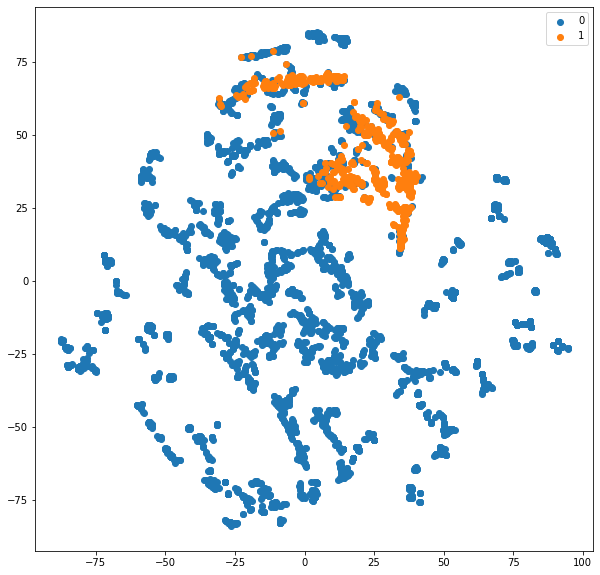

In [12]:
def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
    
plot_tSNE(labels_encoded,x_tsne)

In [13]:
import sys
sys.path.append('../lib')
from data_pre_processing import load_data
sys.path.remove('../lib')
A, X, labels = load_data('c3540', '../data/output')
N = X.shape[0] #the number of nodes
F = X.shape[1]
num_classes = len(set(labels))
print('X shape: ', X.shape)
print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))

(3540, 3540)
(3540, 4)
X shape:  (3540, 4)

Number of nodes (N):  3540

Number of features (F) of each node:  4

Categories:  {'eo', 'ho'}


In [14]:
train_idx,val_idx,test_idx = limit_data(labels)

In [15]:
train_mask = np.zeros((N,),dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,),dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,),dtype=bool)
test_mask[test_idx] = True

In [16]:
print("All Data : \n{}".format(Counter(labels)))
print("Training Data: \n{}".format(Counter([labels[i] for i in train_idx])))
print("Validation Data : \n{}".format(Counter([labels[i] for i in val_idx])))

All Data : 
Counter({'eo': 3134, 'ho': 406})
Training Data: 
Counter({'eo': 20, 'ho': 20})
Validation Data : 
Counter({'eo': 500})


In [17]:
labels_encoded, classes = encode_label(labels)

In [18]:
# Parameters
channels = 16           # Number of channels in the first layer
dropout = 0.5           # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-2    # Learning rate
epochs = 200            # Number of training epochs
es_patience = 10        # Patience for early stopping

# Preprocessing operations
A = GCNConv.preprocess(A).astype('f4')

# Model definition
X_in = Input(shape=(F, ))
fltr_in = Input((None, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GCNConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GCNConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_2, fltr_in])

# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_GCN_cora',
)
callback_GCN = [tbCallBack_GCN]

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 4)            0           input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
gcn_conv_2 (GCNConv)            (None, 16)           64          dropout_2[0][0]                  
                                                                 input_4[0][0]              

In [19]:
X = X.toarray()

In [20]:
validation_data = ([X, A], labels_encoded, val_mask)
model.fit([X, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[
              EarlyStopping(patience=es_patience,  restore_best_weights=True),
              tbCallBack_GCN
          ])

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.2012 - acc: 0.4250 - val_loss: 2.8518 - val_acc: 0.0000e+00
Epoch 2/200
1/1 [==============================] - 1s 841ms/step - loss: 0.1173 - acc: 0.4750 - val_loss: 2.6881 - val_acc: 0.0000e+00
Epoch 3/200
1/1 [==============================] - 0s 86ms/step - loss: 0.1709 - acc: 0.5750 - val_loss: 2.6687 - val_acc: 0.0000e+00
Epoch 4/200
1/1 [==============================] - 0s 87ms/step - loss: 0.1214 - acc: 0.5250 - val_loss: 2.4456 - val_acc: 0.0000e+00
Epoch 5/200
1/1 [==============================] - 0s 86ms/step - loss: 0.1239 - acc: 0.4750 - val_loss: 2.1273 - val_acc: 0.0000e+00
Epoch 6/200
1/1 [==============================] - 0s 91ms/step - loss: 0.1530 - acc: 0.5250 - val_loss: 2.1748 - val_acc: 0.0000e+00
Epoch 7/200
1/1 [==============================] - 0s 91ms/step - loss: 0.1165 - acc: 0.5250 - val_loss: 2.3111 - val_acc: 0.0000e+00
Epoch 8/200
1/1 [==============================] - 0s 97ms/step

In [21]:
X_te = X[test_mask]
A_te = A[test_mask,:][:,test_mask]
y_te = labels_encoded[test_mask]

y_pred = model.predict([X_te, A_te], batch_size=N)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
               precision    recall  f1-score   support

          eo       0.00      0.00      0.00    1000.0
          ho       0.00      0.00      0.00       0.0

    accuracy                           0.00    1000.0
   macro avg       0.00      0.00      0.00    1000.0
weighted avg       0.00      0.00      0.00    1000.0



C:\Users\saura\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saura\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
np.array(labels)

array(['eo', 'eo', 'eo', ..., 'eo', 'ho', 'ho'], dtype='<U2')